In [1]:
! pip install pycocotools scikit-image
! pip install roboflow
from roboflow import Roboflow

! pip install git+https://github.com/facebookresearch/segment-anything.git
! pip install -q git+https://github.com/huggingface/transformers.git
! pip install onnxruntime onnx
! pip install monai

from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from skimage import draw as sk_draw
import numpy as np
import random
import os
from IPython.display import clear_output

from transformers import SamProcessor, SamModel
clear_output()

In [2]:
#! pip uninstall -y torch torchvision
! pip install torch>=2.0.0 torchvision>=0.10.0 --index-url https://download.pytorch.org/whl/cu121

import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim

import torch.nn.functional as F

clear_output()

In [3]:
HOME = os.getcwd()
print(HOME)

/home/junior/Documents/stage-4a-SEDOGBO/model/model1/sam


In [4]:

rf = Roboflow(api_key="K72bvIl0rTcvckcth1sm")
project = rf.workspace("insa-3ptmt").project("simplified")
version = project.version(2)
dataset = version.download("coco-segmentation")

#project = rf.workspace("insa-3ptmt").project("deep_forest")
#version = project.version(1)
#dataset = version.download("coco-segmentation")

clear_output()

/home/junior/Documents/stage-4a-SEDOGBO/model/model1/sam/simplified-2/train
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
Image 0_38_jpeg.rf.164430bfa82fe1662d140d7eb9772b41.jpg avec id =  11
id annot [245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272]
Nombre d'annotations =  28


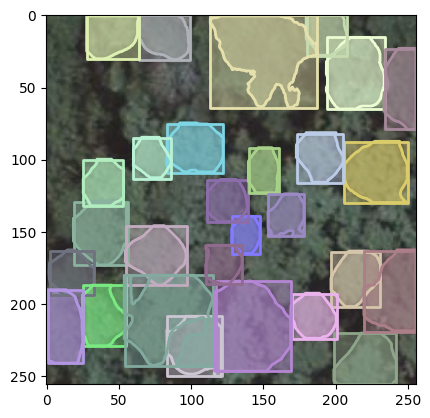

/home/junior/Documents/stage-4a-SEDOGBO/model/model1/sam


In [5]:
%cd {HOME}/simplified-2/train
coco = COCO("_annotations.coco.json")

image_ids = coco.getImgIds()
total = len(image_ids)

for i, img_id in enumerate(image_ids):
    if i < 1 :
        img_id = random.randint(0, total-1)
        img_info = coco.loadImgs(img_id)[0]
        img_path = img_info['file_name']
        print("Image", img_path, "avec id = ", img_id)
        img = cv2.imread(img_path)
        ann_ids = coco.getAnnIds(imgIds=img_id)
        print("id annot" , ann_ids)
        anns = coco.loadAnns(ann_ids)
        print("Nombre d'annotations = ", len(anns))
        plt.imshow(img)
        coco.showAnns(anns, draw_bbox=True)
        plt.show()
%cd {HOME}

In [6]:

class CustomCOCODataset(Dataset):
    def __init__(self, processor, coco_json_path, transform=None, image_dir = ""):
        self.coco = COCO(coco_json_path)
        self.image_dir = image_dir
        self.transform = transform
        self.image_ids = list(self.coco.imgs.keys())
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)
        assert len(img_info) == 1, f"Plus d'une annotation pour l'image {img_id}"
        img_info = img_info[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        image = Image.open(img_path)

        ann_ids = self.coco.getAnnIds(img_id)
        anns = self.coco.loadAnns(ann_ids)
        #print("Image", img_path, "avec id = ", img_id, "comporte ", len(anns), " annotations")
        masks = np.zeros((len(anns), img_info['height'], img_info['width']), dtype=np.uint8)
        object_number = 1
        all_bboxes = []
        for index, ann in enumerate(anns):
            x_min, y_min, width, height = ann['bbox']
            normalized_bbox = (x_min, y_min, x_min + width, y_min + height)
            all_bboxes.append(normalized_bbox)
            for seg in ann['segmentation']:
                rr, cc = sk_draw.polygon(seg[1::2], seg[0::2], masks[index].shape)
                masks[index, rr, cc] = object_number
                object_number += 1
        for _, single_mask in enumerate(masks):
            masks[_] = Image.fromarray(single_mask.astype(np.uint8) * 255)        
        all_bboxes = torch.tensor([all_bboxes])
        if self.transform:
            image = self.transform(image)
        
        masks = (masks > 0).astype(float)
        #print("Mask -- shape : ", masks.shape, "minimum = ", torch.min(torch.tensor(masks)).item(), 'maximum = ', torch.max(torch.tensor(masks)).item())
        #print("Original image -- shape : ", image.shape, "minimum = ", torch.min(image).item(), 'maximum = ', torch.max(image).item())        
        inputs = self.processor(image, input_boxes = all_bboxes, return_tensors = "pt", do_resize=False, do_normalize=False, do_rescale=False)        
        #print("Processed image -- shape : ", inputs['pixel_values'].shape, "minimum = ", torch.min(inputs['pixel_values']).item(), 'maximum = ', torch.max(inputs['pixel_values']).item())        
        inputs = {k:v.squeeze(0) for k, v in inputs.items()}
        inputs["ground_truth_mask"] = masks
        return inputs

In [7]:
%cd {HOME}/simplified-2
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
train_coco_json_path = 'train/_annotations.coco.json'
valid_coco_json_path = 'valid/_annotations.coco.json'
test_coco_json_path = 'test/_annotations.coco.json'

transform = transforms.Compose([
    transforms.ToTensor()
])

/home/junior/Documents/stage-4a-SEDOGBO/model/model1/sam/simplified-2


In [8]:
train_dataset = CustomCOCODataset(processor, train_coco_json_path, transform, "train")
# testing
#inputs = train_dataset.__getitem__(0)

valid_dataset = CustomCOCODataset(processor, valid_coco_json_path, transform, "valid")
test_dataset = CustomCOCODataset(processor, test_coco_json_path, transform, "test")

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, drop_last=False)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=False)
#clear_output()

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Retour processeur SAM :  dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask'])
Input boxes :  torch.Size([1, 13, 4])


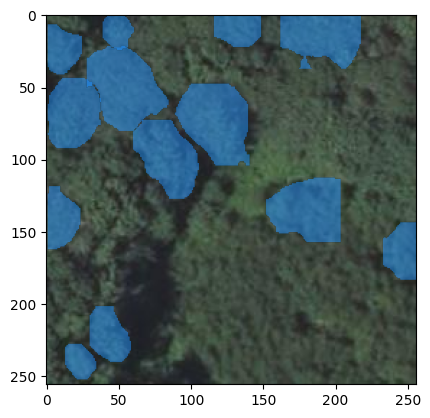

In [9]:
def show_mask(masks, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.3])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.5])
    h, w = masks.shape[-2:]
    for mask in masks:
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

batch = next(iter(train_dataloader))
print("Retour processeur SAM : ", batch.keys())
print("Input boxes : ", batch['input_boxes'].shape)

fig, axes = plt.subplots()
axes.imshow(batch['pixel_values'][0].permute(1, 2, 0).cpu().numpy())
ground_truth_seg = np.array(batch['ground_truth_mask'][0])
show_mask(ground_truth_seg, axes, False)

In [10]:
model = SamModel.from_pretrained("facebook/sam-vit-base")
# Freeze the image and prompt encoders
#print("Model architecture : ")
for name, param in model.named_parameters():
    if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
        param.requires_grad=False
    else:
        param.requires_grad=True
model = model.to(device)

In [11]:
from tqdm import tqdm
from statistics import mean
import monai

criterion = torch.nn.BCELoss() #monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

optimizer = optim.Adam(model.mask_decoder.parameters(), lr=0.01)

num_epochs = 10
train_losses = []
val_losses = []
scores = []

for epoch in range(num_epochs):
    model.train()
    running_loss = []
    batch_score = 0
    for index, train_batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        pixel_values, bounding_boxes = train_batch['pixel_values'].to(device), train_batch['input_boxes'].to(device)
        outputs = model(
            pixel_values=pixel_values, input_boxes=bounding_boxes, 
            multimask_output=False
            )
        score = outputs.iou_scores
        batch_score += score.mean().item()
        #print("IOU score = ", score.mean().item())
        predicted_masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                        train_batch["original_sizes"].cpu(), train_batch["reshaped_input_sizes"].cpu())
        converted_tensors = [tensor.float().requires_grad_() for tensor in predicted_masks]
        stacked_tensor = torch.stack(converted_tensors).squeeze(2)
        predicted_masks = stacked_tensor.to(device)
        ground_truth_masks = train_batch["ground_truth_mask"].to(device, dtype=torch.float).requires_grad_()
        
        #print("Masks -- shape : ", predicted_masks.shape, "minimum = ", torch.min(predicted_masks).item(), 'maximum = ', torch.max(predicted_masks).item())        
        #print("Ground truth -- shape : ", ground_truth_masks.shape, "minimum = ", torch.min(ground_truth_masks).item(), 'maximum = ', torch.max(ground_truth_masks).item())
        
        loss = criterion(predicted_masks, ground_truth_masks)
        #print("Loss = ", loss.item())      
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.item())
        
        if (epoch == 2 or epoch == num_epochs-1) and index < 2:
            fig = plt.figure(figsize=(10, 5))
            print("Batch 1 predictions ")
            size = len(train_batch['pixel_values'])
            for _ in range(size):
                ax = fig.add_subplot(1, size, _+1)
                ax.imshow(train_batch['pixel_values'][_].permute(1, 2, 0).cpu().numpy())
                mask = predicted_masks[_].cpu().detach().numpy()
                show_mask(mask, ax, True)
                plt.show()
                
    #print(running_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean(running_loss) : .4f}', end='  ')
    train_losses.append(mean(running_loss))
    batch_score /= (index+1)
    print("Score batch = ", batch_score)
    scores.append(batch_score)
    #Validation loop
    model.eval()
    val_loss = []
    
    '''
    with torch.no_grad():
        for val_batch in valid_dataloader:
            pixel_values, bounding_boxes = val_batch['pixel_values'].to(device), val_batch['input_boxes'].to(device)
            outputs = model(pixel_values, multimask_output=False)
            
            predicted_masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                        train_batch["original_sizes"].cpu(), train_batch["reshaped_input_sizes"].cpu())
            converted_tensors = [tensor.float() for tensor in predicted_masks]
            stacked_tensor = torch.stack(converted_tensors).squeeze(1)
            predicted_masks = stacked_tensor.to(device)

            ground_truth_masks = val_batch["ground_truth_mask"].float().to(device)
            loss = criterion(predicted_masks, ground_truth_masks)
            val_loss.append(loss.item())
    print(f'Val loss: {mean(val_loss):.4f}')
    val_losses.append(mean(val_loss))
    '''

  2%|▏         | 2/96 [00:02<01:40,  1.07s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 768.00 MiB. GPU 

In [ ]:
nepochs = range(1, len(train_losses)+1)
plt.plot(nepochs, train_losses, "blue")
plt.show()
#plt.plot(nepochs, val_losses, "green")
#plt.show()

In [ ]:
torch.save(model.state_dict(), 'segment_anything_model.pth')

In [ ]:
# Evaluation on test set
model.eval()

test_loss = []

with torch.no_grad():
    for index, test_batch in enumerate(test_dataloader):
        pixel_values, bounding_boxes = test_batch['pixel_values'].to(device), test_batch['input_boxes'].to(device)
        outputs = model(pixel_values, multimask_output=False)
        predicted_masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), 
                        test_batch["original_sizes"].cpu(), test_batch["reshaped_input_sizes"].cpu())
        converted_tensors = [tensor.float() for tensor in predicted_masks]
        stacked_tensor = torch.stack(converted_tensors).squeeze(1)
        predicted_masks = stacked_tensor.to(device)
        ground_truth_masks = test_batch["ground_truth_mask"].float().to(device)
        loss = criterion(predicted_masks, ground_truth_masks)
        test_loss.append(loss.item())
        
        if index < 10:
            fig = plt.figure(figsize=(10, 5))
            size = len(test_batch['pixel_values'])
            for _ in range(size):
                ax = fig.add_subplot(1, size, _+1)
                ax.imshow(test_batch['pixel_values'][_].permute(1, 2, 0).cpu().numpy())
                mask = predicted_masks[_].cpu().numpy()
                #print("minimum = ", np.min(mask), 'maximum = ', np.max(mask))
                show_mask(mask, ax, True)
                plt.show()
    
    print(f'Test Loss: {mean(test_loss):.4f}')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Créer une figure de taille 15x15 pouces
fig = plt.figure(figsize=(15, 15))

# Créer une image aléatoire pour l'exemple
image = np.random.rand(100, 100, 3)

# Ajouter un subplot
ax = fig.add_subplot(1, 1, 1)

# Afficher l'image
ax.imshow(image)

# Ajouter un titre à l'image
ax.set_title('Exemple d\'image')

# Afficher la figure
plt.show()
